In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")




In [68]:
df=pd.read_csv("weather_cleaned.csv")

In [34]:
df.columns

Index(['time', 'temp_2m', 'humidity_2m', 'dew_point_2m', 'precip', 'snowfall',
       'snow_depth', 'msl_pressure', 'surface_pressure', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'et0', 'vpd', 'wind_speed_10m',
       'wind_dir_10m', 'soil_temp_0_7cm', 'soil_moisture_0_7cm',
       'location_city', 'latitude', 'longitude', 'weather_Clear sky',
       'weather_Drizzle: Dense', 'weather_Drizzle: Light',
       'weather_Drizzle: Moderate', 'weather_Mainly clear', 'weather_Overcast',
       'weather_Partly cloudy', 'weather_Rain: Heavy',
       'weather_Rain: Moderate', 'weather_Rain: Slight',
       'weather_Snow fall: Heavy', 'weather_Snow fall: Moderate',
       'weather_Snow fall: Slight'],
      dtype='object')

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [69]:
df=pd.read_csv("weather_cleaned.csv")

In [44]:
# Assuming 'df' is your full DataFrame with all cities
# Filter data for "St. Louis" city
st_louis_data = df[df['location_city'] == 'St. Louis']

# Ensure the 'time' column is a datetime object
st_louis_data['time'] = pd.to_datetime(st_louis_data['time'])

# Set 'time' as the index for proper resampling
st_louis_data.set_index('time', inplace=True)


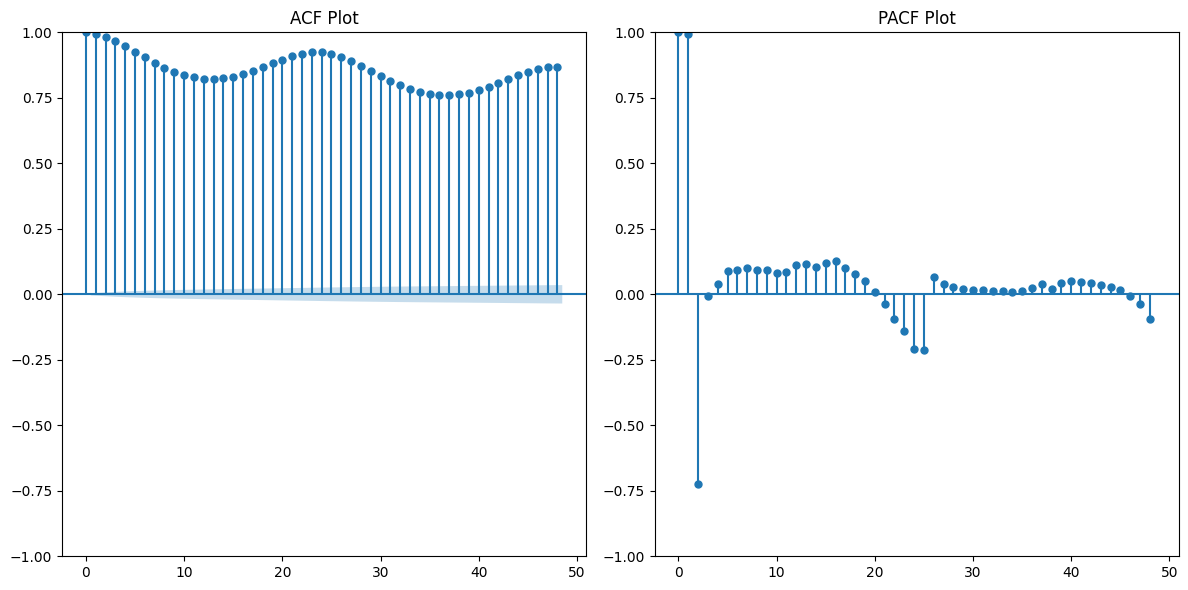

In [45]:


hourly_data = st_louis_data.select_dtypes(include=[np.number]).resample('H').mean()



plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(hourly_data['temp_2m'], lags=48, ax=plt.gca())
plt.title("ACF Plot")

plt.subplot(122)
plot_pacf(hourly_data['temp_2m'], lags=48, ax=plt.gca())
plt.title("PACF Plot")

plt.tight_layout()
plt.show()


In [46]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt


# Resample to hourly frequency and compute the mean (if needed)
hourly_data = st_louis_data.select_dtypes(include=[np.number]).resample('H').mean()

# Splitting data into train and test sets (80% train, 20% test)
train_size = int(len(hourly_data) * 0.8)
train, test = hourly_data[:train_size], hourly_data[train_size:]

# Use auto_arima to automatically determine the best SARIMA parameters
model = auto_arima(
    train['temp_2m'],       # Target variable
    start_p=1, start_q=1,   # Start values for p and q
    max_p=5, max_q=5,       # Maximum values for p and q
    seasonal=True,          # Enable seasonal SARIMA
    m=24,                   # Seasonal period (e.g., 24 for hourly data with daily seasonality)
    start_P=0, start_Q=0,   # Start values for seasonal P and Q
    max_P=2, max_Q=2,       # Maximum values for seasonal P and Q
    trace=True,             # Display progress
    stepwise=True,          # Use stepwise search for faster computation
    suppress_warnings=True, # Suppress warnings
    error_action="ignore"   # Ignore non-convergence issues
)

# Print the best model summary
print("Best Model Summary:")
print(model.summary())

# Forecast on the test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Plot the forecast vs actual test values
plt.figure(figsize=(12, 6))
plt.plot(train['temp_2m'], label='Train Data', color='blue')
plt.plot(test['temp_2m'], label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.fill_between(
    test.index,
    conf_int[:, 0],
    conf_int[:, 1],
    color='pink',
    alpha=0.3
)
plt.title('SARIMA Forecast for St. Louis', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['temp_2m'], forecast)
mse = mean_squared_error(test['temp_2m'], forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=565400.598, Time=11.50 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=710542.649, Time=1.96 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=537481.816, Time=83.49 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=582833.231, Time=96.11 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=710540.650, Time=1.13 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=565941.112, Time=3.80 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=525973.812, Time=368.73 sec


KeyboardInterrupt: 

# LSTM

In [60]:
df=pd.read_csv("weather_cleaned.csv")

In [70]:
import pandas as pd
import numpy as np
import torch

# Convert boolean columns to integers (0 and 1)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Encode the city names as integers
df['city_idx'] = df['location_city'].astype('category').cat.codes  # Numeric index for each city
features = ['humidity_2m', 'dew_point_2m', 'precip', 'snowfall', 'snow_depth', 
            'msl_pressure', 'surface_pressure', 'cloud_cover_low', 'cloud_cover_mid',
            'cloud_cover_high', 'et0', 'vpd', 'wind_speed_10m', 'wind_dir_10m', 
            'soil_temp_0_7cm', 'soil_moisture_0_7cm', 'latitude', 'longitude'] + \
           [col for col in df.columns if col.startswith('weather_')]

target = 'temp_2m'
T = 3  # Number of timesteps
input_dim = len(features)

# Lists to hold training and testing data across all cities
X_train_list, y_train_list, city_train_list = [], [], []
X_test_list, y_test_list, city_test_list = [], [], []

# To compute normalization statistics
all_train_data = []

# Process each city independently
for city_id, city_data in df.groupby('city_idx'):
    city_data = city_data.sort_values(by='time').reset_index(drop=True)
    input_data = city_data[features].values
    targets = city_data[target].values
    
    # Determine train size for the current city
    N = len(input_data) - T  # Total number of sequences
    train_size = int(0.90 * N)
    
    # Split data for normalization calculation (only on training set)
    train_data = input_data[:train_size]
    all_train_data.append(train_data)  # Collect all training data for global normalization
    
    # Convert to torch tensors
    input_data_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(targets, dtype=torch.float32)
    
    # Initialize train and test tensors for this city
    X_train_city = torch.zeros((train_size, T, input_dim), dtype=torch.float32)
    y_train_city = torch.zeros((train_size, 1), dtype=torch.float32)
    X_test_city = torch.zeros((N - train_size, T, input_dim), dtype=torch.float32)
    y_test_city = torch.zeros((N - train_size, 1), dtype=torch.float32)
    
    # Prepare training sequences
    for t in range(train_size):
        X_train_city[t] = input_data_tensor[t:t + T]
        y_train_city[t] = target_tensor[t + T]
    
    # Prepare testing sequences
    for i in range(N - train_size):
        t = i + train_size
        X_test_city[i] = input_data_tensor[t:t + T]
        y_test_city[i] = target_tensor[t + T]
    
    # Prepare city indices for train and test
    city_train_city = torch.full((train_size,), city_id, dtype=torch.long)
    city_test_city = torch.full((N - train_size,), city_id, dtype=torch.long)
    
    # Append city-specific data to the main lists
    X_train_list.append(X_train_city)
    y_train_list.append(y_train_city)
    city_train_list.append(city_train_city)
    
    X_test_list.append(X_test_city)
    y_test_list.append(y_test_city)
    city_test_list.append(city_test_city)

# Concatenate all training data for normalization calculation
all_train_data = np.vstack(all_train_data)
train_mean = all_train_data.mean(axis=0)
train_std = all_train_data.std(axis=0)

# Concatenate all cities’ data to form the final tensors
X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
city_train = torch.cat(city_train_list, dim=0)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
city_test = torch.cat(city_test_list, dim=0)

# Normalize X_train and X_test
train_mean_tensor = torch.tensor(train_mean, dtype=torch.float32)
train_std_tensor = torch.tensor(train_std, dtype=torch.float32)

# Normalize along the feature dimension (last dimension)
X_train = (X_train - train_mean_tensor) / train_std_tensor
X_test = (X_test - train_mean_tensor) / train_std_tensor

# Print shapes to confirm the results
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("city_train shape:", city_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("city_test shape:", city_test.shape)


X_train shape: torch.Size([977490, 3, 31])
y_train shape: torch.Size([977490, 1])
city_train shape: torch.Size([977490])
X_test shape: torch.Size([108615, 3, 31])
y_test shape: torch.Size([108615, 1])
city_test shape: torch.Size([108615])


In [51]:
# Create a mapping between city_idx and location_city
city_mapping = df[['city_idx', 'location_city']].drop_duplicates()




In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print("Using device:", device)

# LSTM Model with Embedding
class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Output from the last timestep
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x


# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
hidden_size=128
dropout=0.39
batch_size = 64
embedding_dim = 7 # Dimension of the embedding layer


# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [53]:
# Recreate the model with the same architecture
model = LSTMModelWithEmbedding(input_dim=input_dim, num_cities=num_cities, embedding_dim=embedding_dim,hidden_size=hidden_size,dropout=dropout).to(device)

# Load the saved checkpoint
checkpoint_path = "/home/research/a.naveen/denoise40/weather/lstm/best_model.pth"
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

LSTMModelWithEmbedding(
  (city_embedding): Embedding(5, 7)
  (lstm): LSTM(38, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.39, inplace=False)
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=8, bias=True)
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

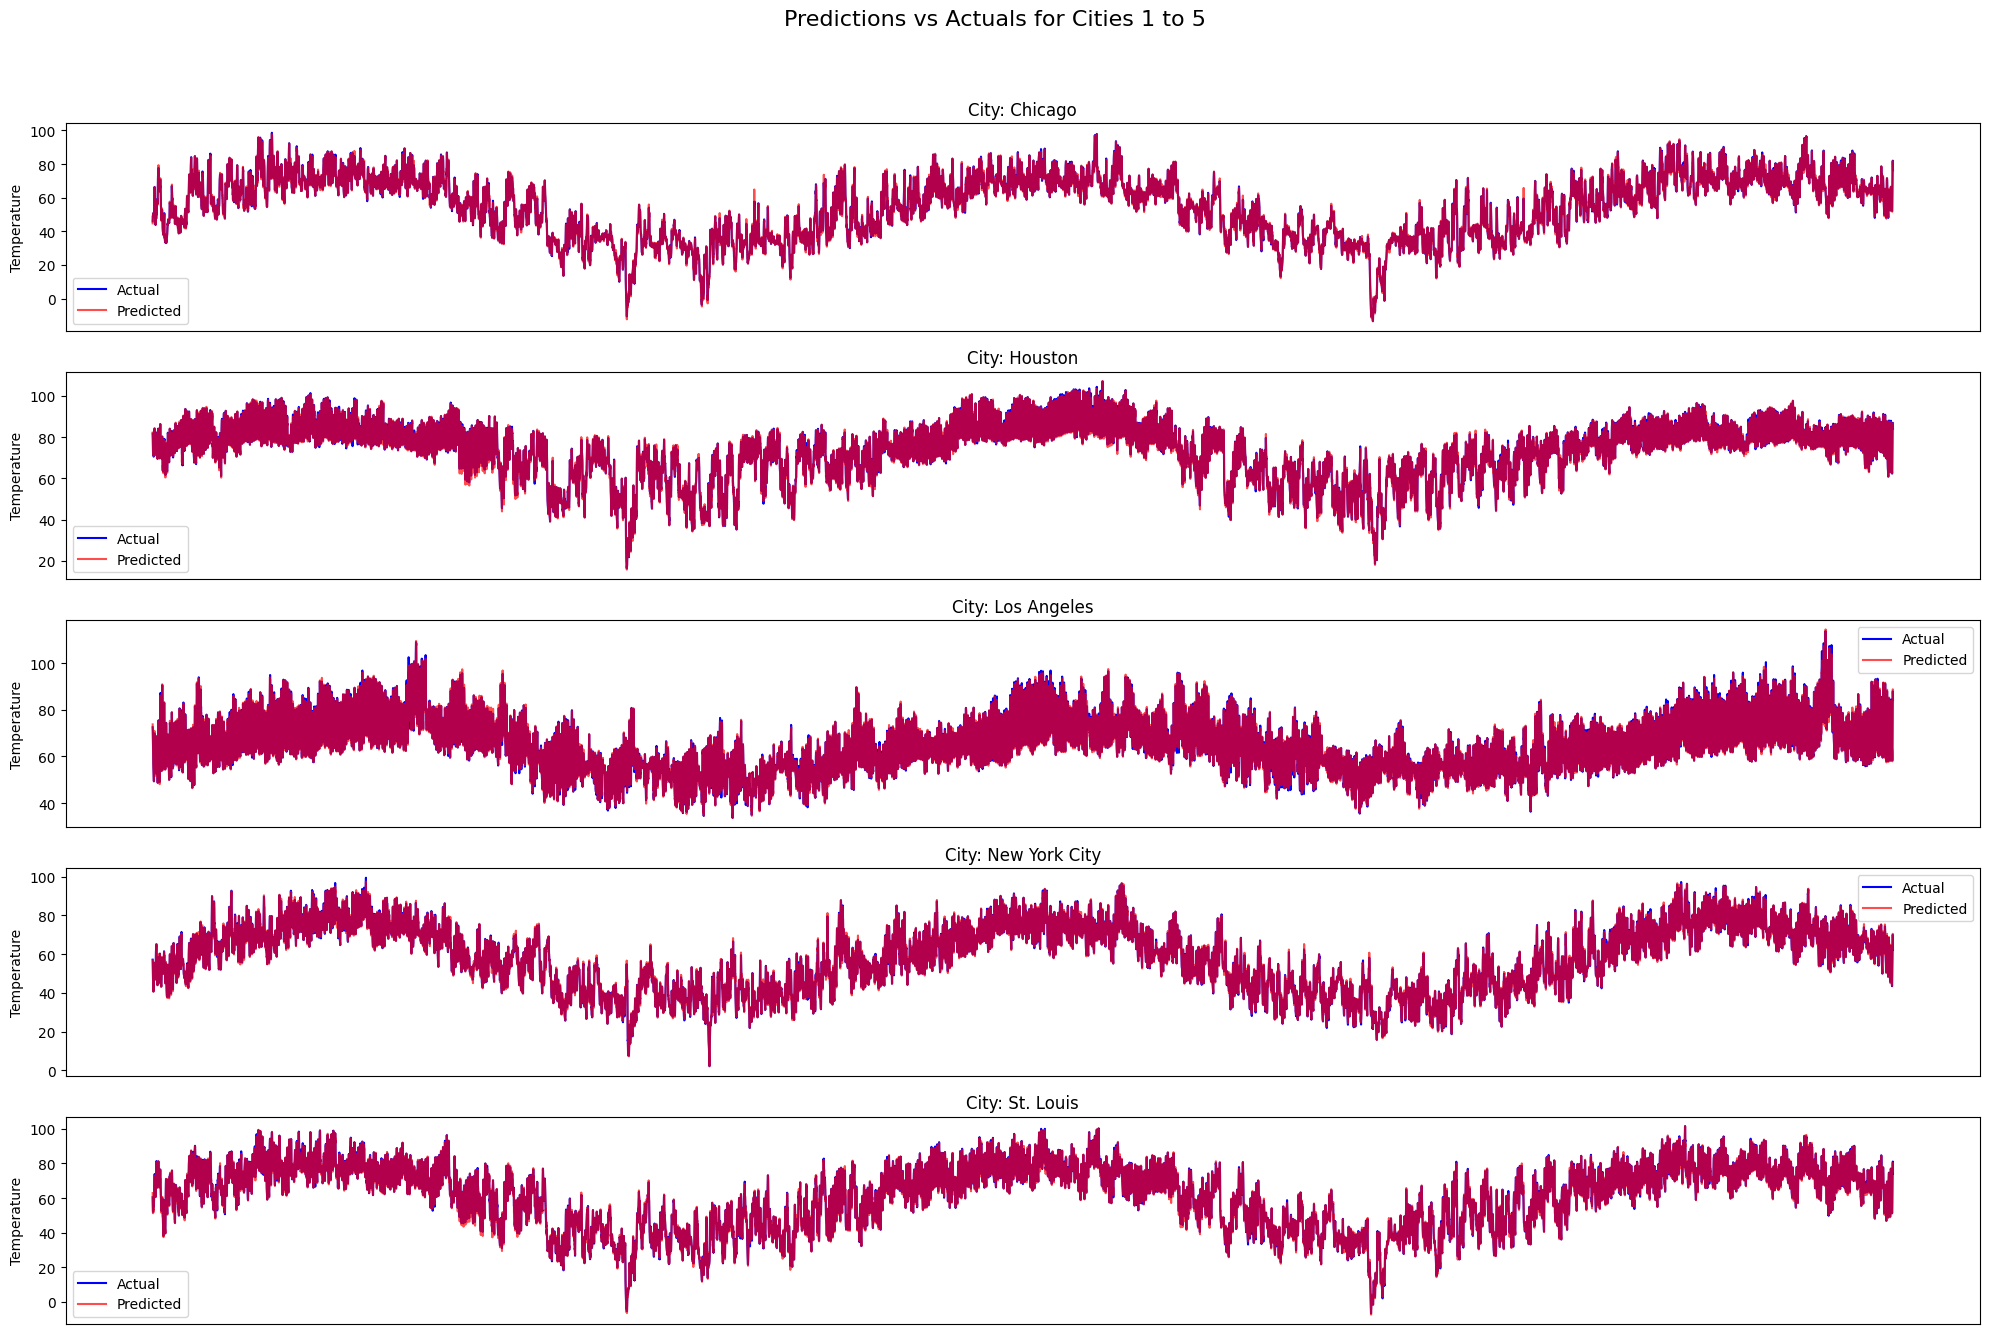

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Generate predictions on the test set, grouped by city
model.eval()
predictions = []
actuals = []
city_indices = []

with torch.no_grad():
    for X_batch, y_batch, city_batch in test_loader:
        output = model(X_batch, city_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())
        city_indices.extend(city_batch.cpu().numpy())

# Convert lists to NumPy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()
city_indices = np.array(city_indices)

# Get unique city indices for plotting city-wise
unique_cities = np.unique(city_indices)
num_cities = len(unique_cities)

# Plot predictions vs actual values for each city with subplots, 5 per figure
cities_per_fig = 5
num_figs = int(np.ceil(num_cities / cities_per_fig))

for fig_num in range(num_figs):
    start_idx = fig_num * cities_per_fig
    end_idx = min(start_idx + cities_per_fig, num_cities)
    cities_to_plot = unique_cities[start_idx:end_idx]
    
    fig, axes = plt.subplots(len(cities_to_plot), 1, figsize=(20, 14))
    fig.suptitle(f'Predictions vs Actuals for Cities {start_idx + 1} to {end_idx}', fontsize=16)
    
    if len(cities_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot

    for ax, city_id in zip(axes, cities_to_plot):
        city_mask = city_indices == city_id
        city_predictions = predictions[city_mask]
        city_actuals = actuals[city_mask]
        
        # Get city name from mapping
        city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
        
        ax.plot(city_actuals, label='Actual', color='blue')
        ax.plot(city_predictions, label='Predicted', color='red', alpha=0.7)
        ax.set_title(f'City: {city_name}')
        
        ax.set_ylabel('Temperature')
        # Remove x-axis values
        ax.set_xticks([])
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


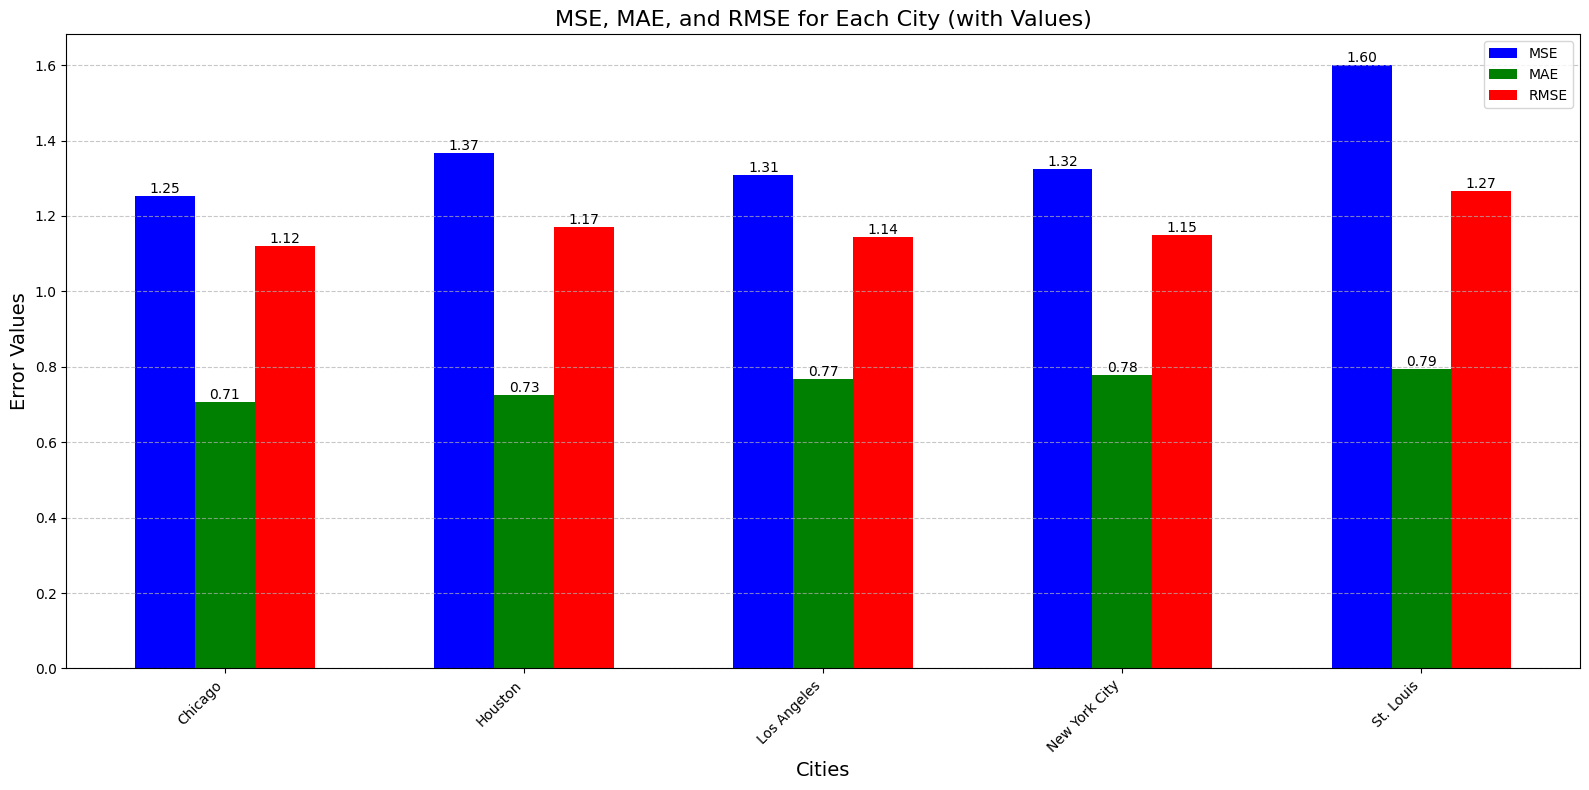

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Initialize a dictionary to store metrics for each city
city_metrics = {}

# Loop through each unique city index
for city_id in np.unique(city_indices):
    # Mask to filter data for the current city
    city_mask = city_indices == city_id
    city_predictions = predictions[city_mask]
    city_actuals = actuals[city_mask]
    
    # Calculate metrics
    mse = mean_squared_error(city_actuals, city_predictions)
    mae = mean_absolute_error(city_actuals, city_predictions)
    rmse = np.sqrt(mse)
    
    # Get the city name
    city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
    
    # Store metrics
    city_metrics[city_name] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Prepare data for plotting
cities = list(city_metrics.keys())
mse_values = [metrics["MSE"] for metrics in city_metrics.values()]
mae_values = [metrics["MAE"] for metrics in city_metrics.values()]
rmse_values = [metrics["RMSE"] for metrics in city_metrics.values()]

# Plot MSE, MAE, and RMSE as bar charts
x = np.arange(len(cities))  # City indices for the x-axis

plt.figure(figsize=(16, 8))

# Plot MSE
mse_bars = plt.bar(x - 0.2, mse_values, width=0.2, label='MSE', color='blue')

# Plot MAE
mae_bars = plt.bar(x, mae_values, width=0.2, label='MAE', color='green')

# Plot RMSE
rmse_bars = plt.bar(x + 0.2, rmse_values, width=0.2, label='RMSE', color='red')

# Add values on top of bars
for bars, values in zip([mse_bars, mae_bars, rmse_bars], [mse_values, mae_values, rmse_values]):
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            bar.get_height(),                  # Y position (top of the bar)
            f"{value:.2f}",                    # Value (rounded to 2 decimal places)
            ha='center', va='bottom', fontsize=10  # Alignment and font size
        )

# Add labels and title
plt.xticks(x, cities, rotation=45, ha='right')
plt.xlabel('Cities', fontsize=14)
plt.ylabel('Error Values', fontsize=14)
plt.title('MSE, MAE, and RMSE for Each City (with Values)', fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


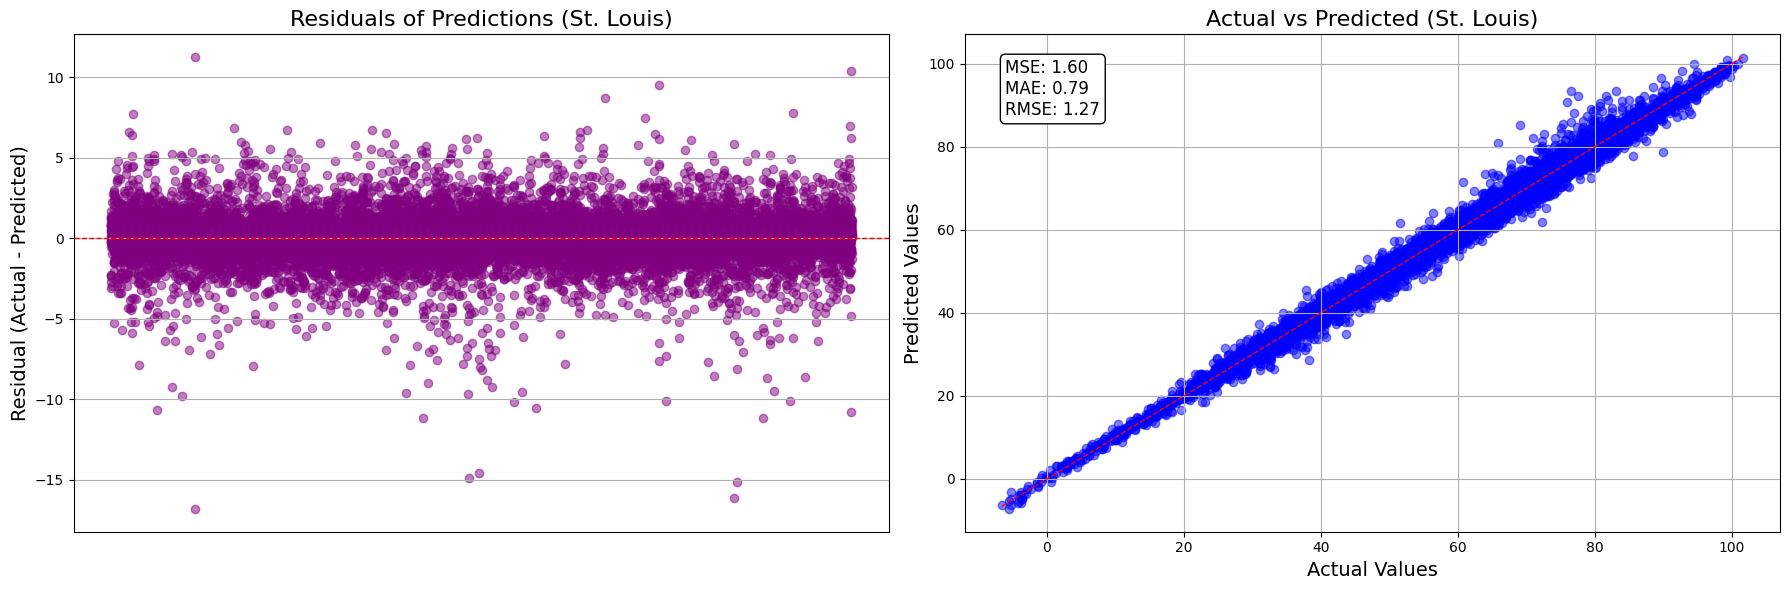

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Identify the city index for St. Louis
st_louis_idx = city_mapping[city_mapping['location_city'] == 'St. Louis']['city_idx'].values[0]

# Filter data for St. Louis
st_louis_mask = city_indices == st_louis_idx
st_louis_actuals = actuals[st_louis_mask]
st_louis_predictions = predictions[st_louis_mask]

# Calculate residuals for St. Louis
st_louis_residuals = st_louis_actuals - st_louis_predictions

# Calculate metrics for St. Louis
mse = mean_squared_error(st_louis_actuals, st_louis_predictions)
mae = mean_absolute_error(st_louis_actuals, st_louis_predictions)
rmse = np.sqrt(mse)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Residuals for St. Louis
axes[0].scatter(range(len(st_louis_residuals)), st_louis_residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals of Predictions (St. Louis)', fontsize=16)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=14)
axes[0].grid(True)
axes[0].set_xticks([])  # Remove x-axis values

# Subplot 2: Actual vs Predicted for St. Louis
axes[1].scatter(st_louis_actuals, st_louis_predictions, alpha=0.5, color='blue')
axes[1].plot([min(st_louis_actuals), max(st_louis_actuals)], 
             [min(st_louis_actuals), max(st_louis_actuals)], 
             color='red', linestyle='--', linewidth=1)  # Perfect prediction line
axes[1].set_title('Actual vs Predicted (St. Louis)', fontsize=16)
axes[1].set_xlabel('Actual Values', fontsize=14)
axes[1].set_ylabel('Predicted Values', fontsize=14)
axes[1].grid(True)

# Display error metrics on the second subplot
text_x = 0.05  # X-coordinate for text (relative to axis)
text_y = 0.95  # Y-coordinate for text (relative to axis)
axes[1].text(
    text_x, text_y, 
    f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Adjust layout
plt.tight_layout()
plt.show()


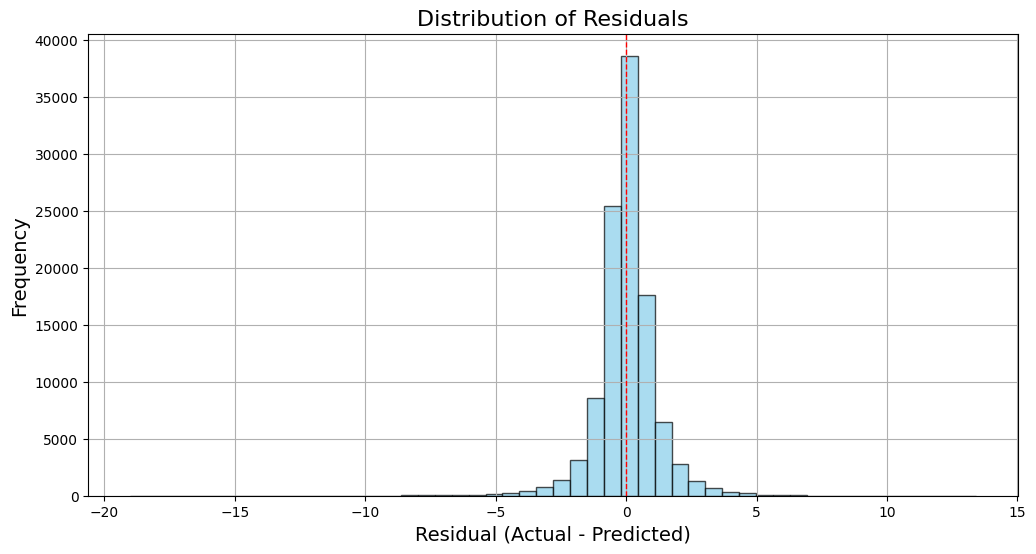

In [16]:
import matplotlib.pyplot as plt

# Plot distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual (Actual - Predicted)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


# CNN

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class CNNModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_channels1, num_channels2, embedding_dim, num_cities, dropout_rate):
        super(CNNModelWithEmbedding, self).__init__()
        
        # Embedding for city index
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_dim + embedding_dim, out_channels=num_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_channels1, out_channels=num_channels2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Fully connected layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(num_channels2 * (T // 2), 64)  # Adjust based on sequence length (T)
        self.fc2 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x, city_idx):
        # Add city embeddings
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        
        # Permute for CNN (channels-first format)
        x = x.permute(0, 2, 1)
        
        # Pass through CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Pass through fully connected layers
        x = self.dropout(self.fc1(x))
        x = self.relu(x)
        x = self.dropout(self.fc2(x))
        x = self.relu(x)
        x = self.output(x)
        
        return x
    
    
    

# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
batch_size = 64
embedding_dim = 9 # Dimension of the embedding layer
num_channels1=48
num_channels2=80
dropout_rate=0.25



# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [63]:
# Recreate the model with the same architecture
model  = CNNModelWithEmbedding(
            input_dim=X_train.shape[2],
            num_channels1=num_channels1,
            num_channels2=num_channels2,
            embedding_dim=embedding_dim,
            num_cities=city_train.max().item() + 1,
            dropout_rate=dropout_rate
        ).to(device).to(device)

# Load the saved checkpoint
checkpoint_path = "/home/research/a.naveen/denoise40/weather/cnn/best_model.pth"
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

CNNModelWithEmbedding(
  (city_embedding): Embedding(5, 9)
  (conv1): Conv1d(40, 48, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(48, 80, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=80, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

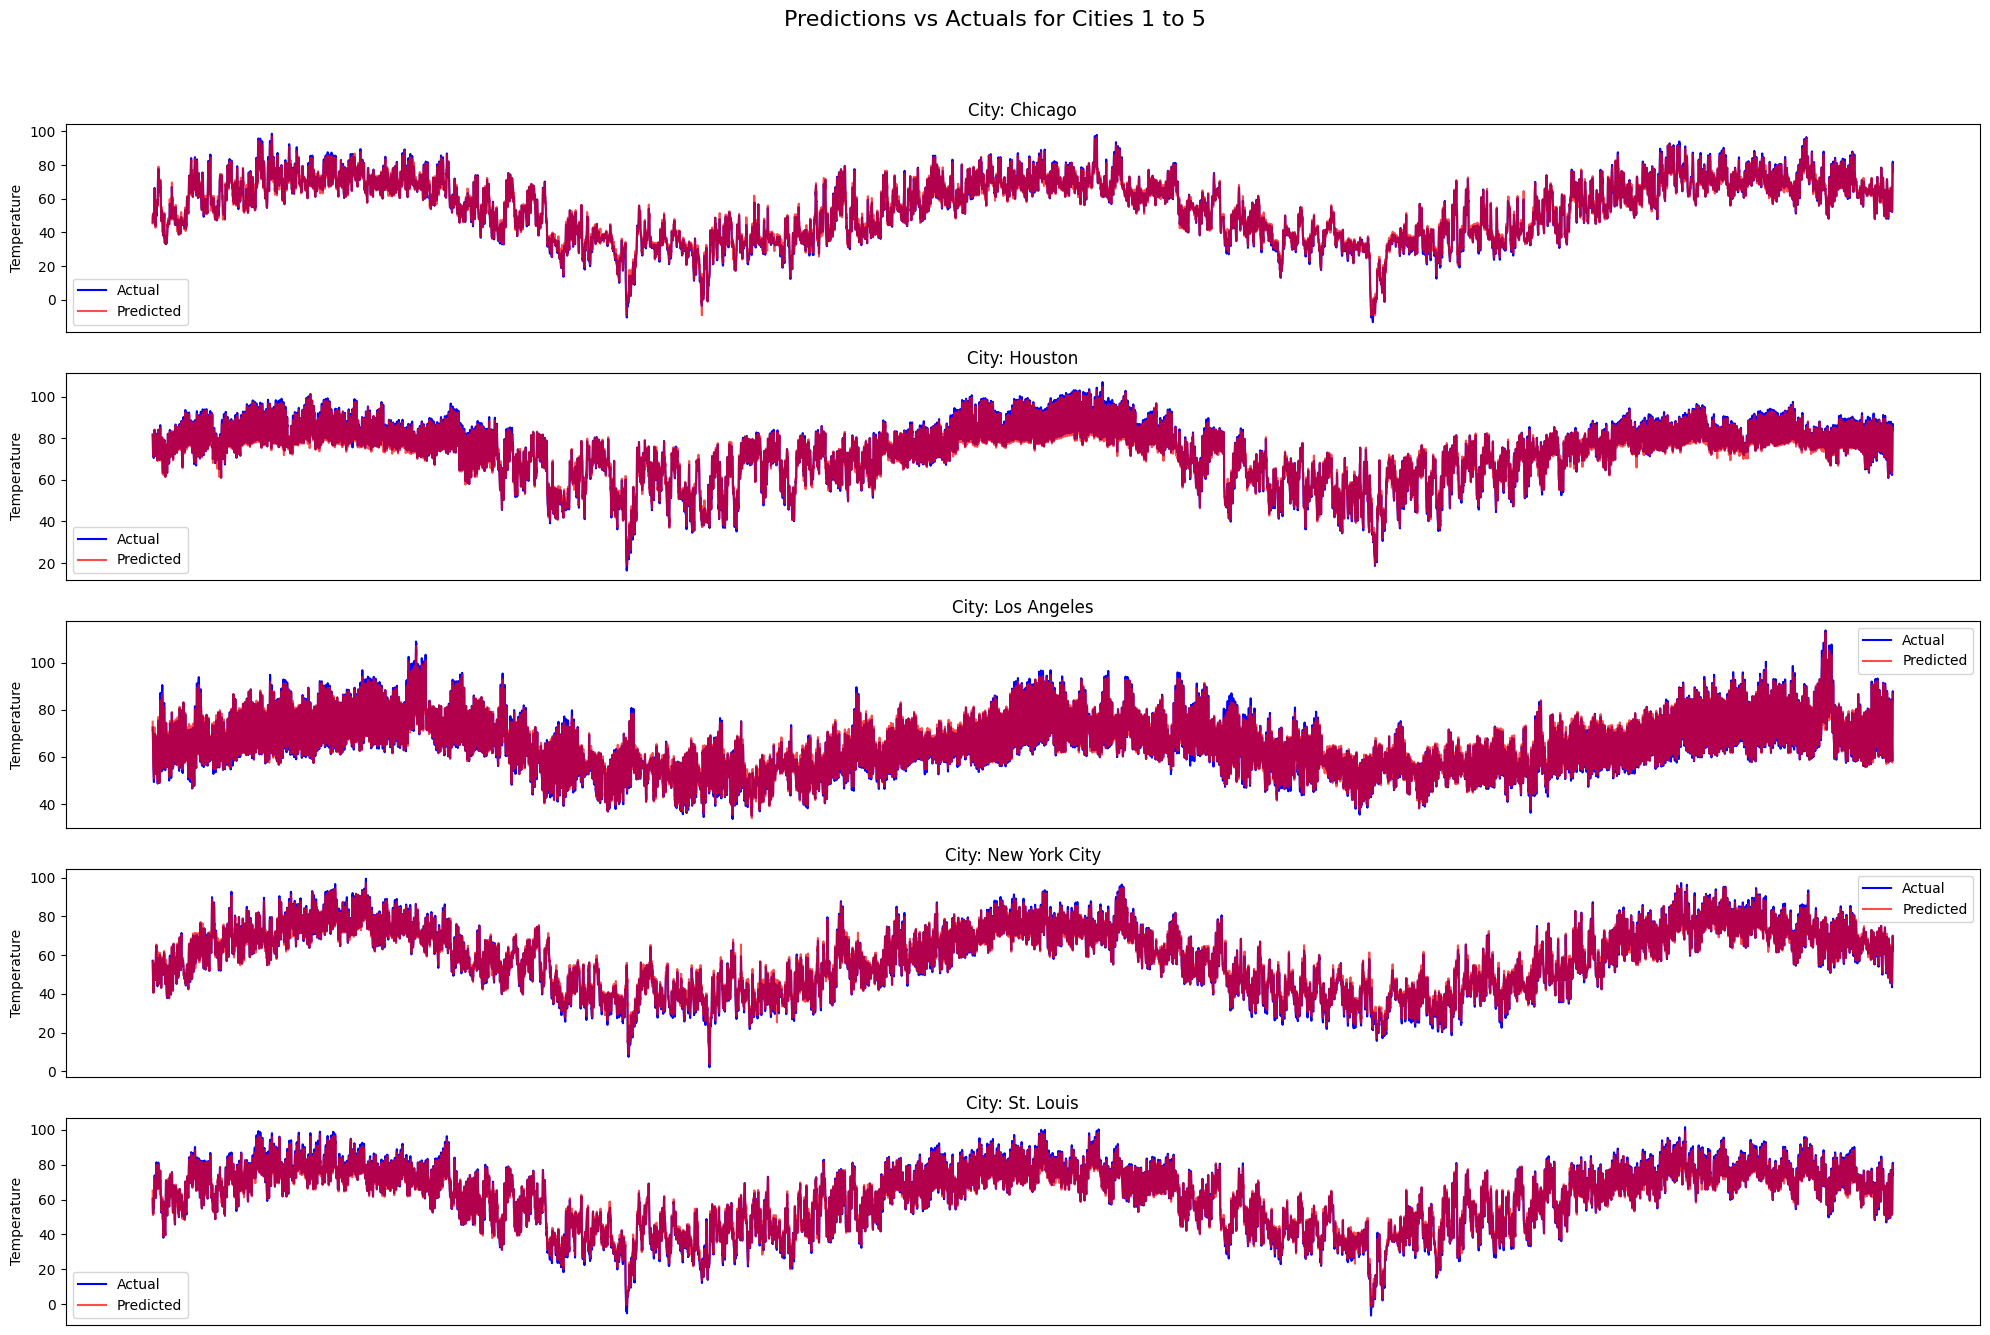

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Generate predictions on the test set, grouped by city
model.eval()
predictions = []
actuals = []
city_indices = []

with torch.no_grad():
    for X_batch, y_batch, city_batch in test_loader:
        output = model(X_batch, city_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())
        city_indices.extend(city_batch.cpu().numpy())

# Convert lists to NumPy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()
city_indices = np.array(city_indices)

# Get unique city indices for plotting city-wise
unique_cities = np.unique(city_indices)
num_cities = len(unique_cities)

# Plot predictions vs actual values for each city with subplots, 5 per figure
cities_per_fig = 5
num_figs = int(np.ceil(num_cities / cities_per_fig))

for fig_num in range(num_figs):
    start_idx = fig_num * cities_per_fig
    end_idx = min(start_idx + cities_per_fig, num_cities)
    cities_to_plot = unique_cities[start_idx:end_idx]
    
    fig, axes = plt.subplots(len(cities_to_plot), 1, figsize=(20, 14))
    fig.suptitle(f'Predictions vs Actuals for Cities {start_idx + 1} to {end_idx}', fontsize=16)
    
    if len(cities_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot

    for ax, city_id in zip(axes, cities_to_plot):
        city_mask = city_indices == city_id
        city_predictions = predictions[city_mask]
        city_actuals = actuals[city_mask]
        
        # Get city name from mapping
        city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
        
        ax.plot(city_actuals, label='Actual', color='blue')
        ax.plot(city_predictions, label='Predicted', color='red', alpha=0.7)
        ax.set_title(f'City: {city_name}')
        
        ax.set_ylabel('Temperature')
        # Remove x-axis values
        ax.set_xticks([])
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


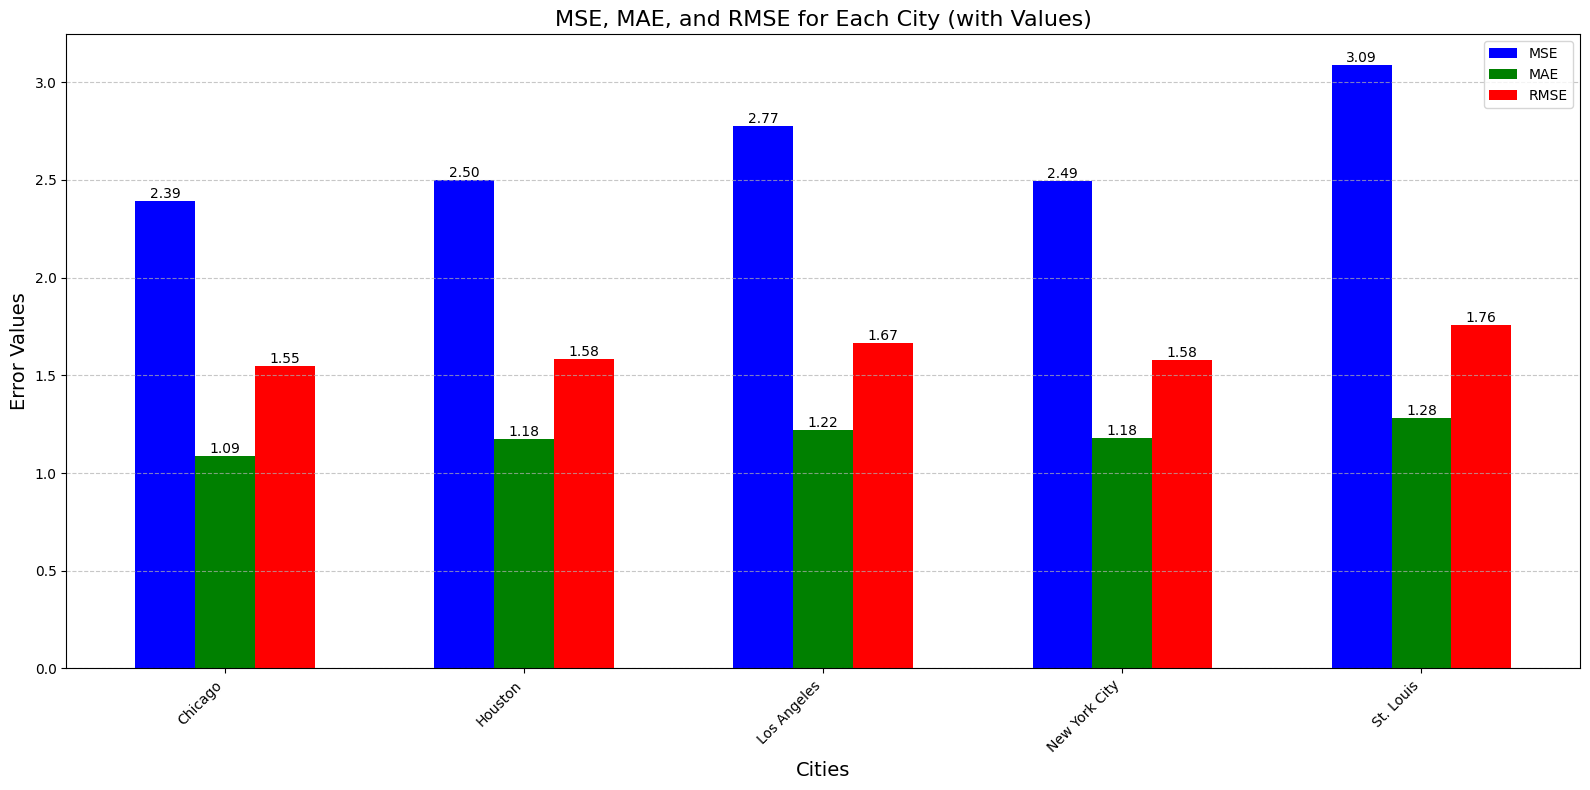

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Initialize a dictionary to store metrics for each city
city_metrics = {}

# Loop through each unique city index
for city_id in np.unique(city_indices):
    # Mask to filter data for the current city
    city_mask = city_indices == city_id
    city_predictions = predictions[city_mask]
    city_actuals = actuals[city_mask]
    
    # Calculate metrics
    mse = mean_squared_error(city_actuals, city_predictions)
    mae = mean_absolute_error(city_actuals, city_predictions)
    rmse = np.sqrt(mse)
    
    # Get the city name
    city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
    
    # Store metrics
    city_metrics[city_name] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Prepare data for plotting
cities = list(city_metrics.keys())
mse_values = [metrics["MSE"] for metrics in city_metrics.values()]
mae_values = [metrics["MAE"] for metrics in city_metrics.values()]
rmse_values = [metrics["RMSE"] for metrics in city_metrics.values()]

# Plot MSE, MAE, and RMSE as bar charts
x = np.arange(len(cities))  # City indices for the x-axis

plt.figure(figsize=(16, 8))

# Plot MSE
mse_bars = plt.bar(x - 0.2, mse_values, width=0.2, label='MSE', color='blue')

# Plot MAE
mae_bars = plt.bar(x, mae_values, width=0.2, label='MAE', color='green')

# Plot RMSE
rmse_bars = plt.bar(x + 0.2, rmse_values, width=0.2, label='RMSE', color='red')

# Add values on top of bars
for bars, values in zip([mse_bars, mae_bars, rmse_bars], [mse_values, mae_values, rmse_values]):
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            bar.get_height(),                  # Y position (top of the bar)
            f"{value:.2f}",                    # Value (rounded to 2 decimal places)
            ha='center', va='bottom', fontsize=10  # Alignment and font size
        )

# Add labels and title
plt.xticks(x, cities, rotation=45, ha='right')
plt.xlabel('Cities', fontsize=14)
plt.ylabel('Error Values', fontsize=14)
plt.title('MSE, MAE, and RMSE for Each City (with Values)', fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


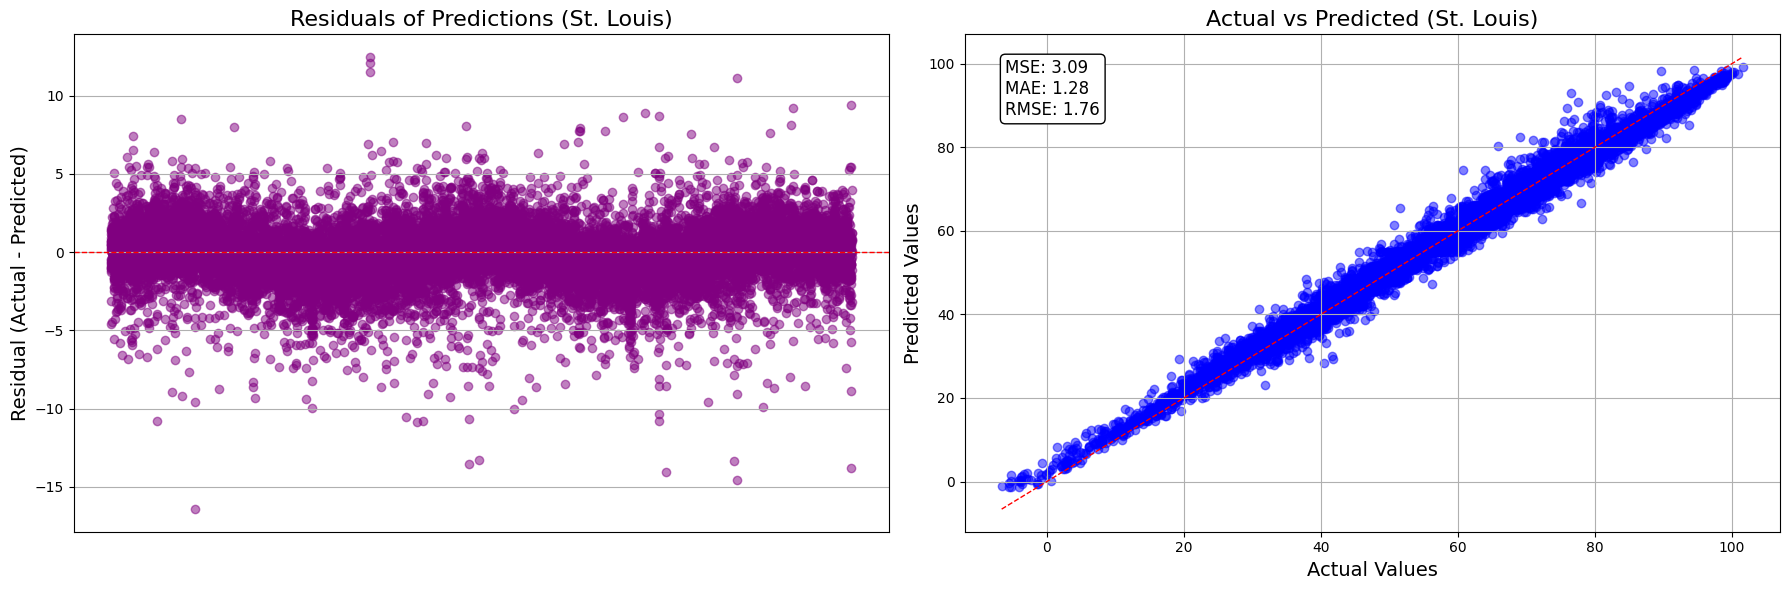

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Identify the city index for St. Louis
st_louis_idx = city_mapping[city_mapping['location_city'] == 'St. Louis']['city_idx'].values[0]

# Filter data for St. Louis
st_louis_mask = city_indices == st_louis_idx
st_louis_actuals = actuals[st_louis_mask]
st_louis_predictions = predictions[st_louis_mask]

# Calculate residuals for St. Louis
st_louis_residuals = st_louis_actuals - st_louis_predictions

# Calculate metrics for St. Louis
mse = mean_squared_error(st_louis_actuals, st_louis_predictions)
mae = mean_absolute_error(st_louis_actuals, st_louis_predictions)
rmse = np.sqrt(mse)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Residuals for St. Louis
axes[0].scatter(range(len(st_louis_residuals)), st_louis_residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals of Predictions (St. Louis)', fontsize=16)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=14)
axes[0].grid(True)
axes[0].set_xticks([])  # Remove x-axis values

# Subplot 2: Actual vs Predicted for St. Louis
axes[1].scatter(st_louis_actuals, st_louis_predictions, alpha=0.5, color='blue')
axes[1].plot([min(st_louis_actuals), max(st_louis_actuals)], 
             [min(st_louis_actuals), max(st_louis_actuals)], 
             color='red', linestyle='--', linewidth=1)  # Perfect prediction line
axes[1].set_title('Actual vs Predicted (St. Louis)', fontsize=16)
axes[1].set_xlabel('Actual Values', fontsize=14)
axes[1].set_ylabel('Predicted Values', fontsize=14)
axes[1].grid(True)

# Display error metrics on the second subplot
text_x = 0.05  # X-coordinate for text (relative to axis)
text_y = 0.95  # Y-coordinate for text (relative to axis)
axes[1].text(
    text_x, text_y, 
    f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Adjust layout
plt.tight_layout()
plt.show()


# LSTM_ATTENTION

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# LSTM Model with Attention and Embedding
class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        
        # Attention Layer
        self.attention = nn.Linear(hidden_size * 2, 1)  # Bidirectional LSTM output size is `hidden_size * 2`
        
        # Fully connected layers
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        # City embedding
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        
        # LSTM
        lstm_output, _ = self.lstm(x)  # Shape: (batch_size, seq_len, hidden_size * 2)
        
        # Attention Mechanism
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)  # Shape: (batch_size, seq_len, 1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # Weighted sum over timesteps
        
        # Fully connected layers
        x = self.dropout(context_vector)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
hidden_size = 128
dropout = 0.39
batch_size = 64
embedding_dim = 7  # Dimension of the embedding layer



# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [72]:
# Recreate the model with the same architecture
model = LSTMModelWithAttention(input_dim=input_dim, num_cities=num_cities, embedding_dim=embedding_dim, hidden_size=hidden_size, dropout=dropout).to(device)

# Load the saved checkpoint
checkpoint_path = "/home/research/a.naveen/denoise40/weather/lstm/best_attention_model.pth"
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

LSTMModelWithAttention(
  (city_embedding): Embedding(5, 7)
  (lstm): LSTM(38, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.39, inplace=False)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=8, bias=True)
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

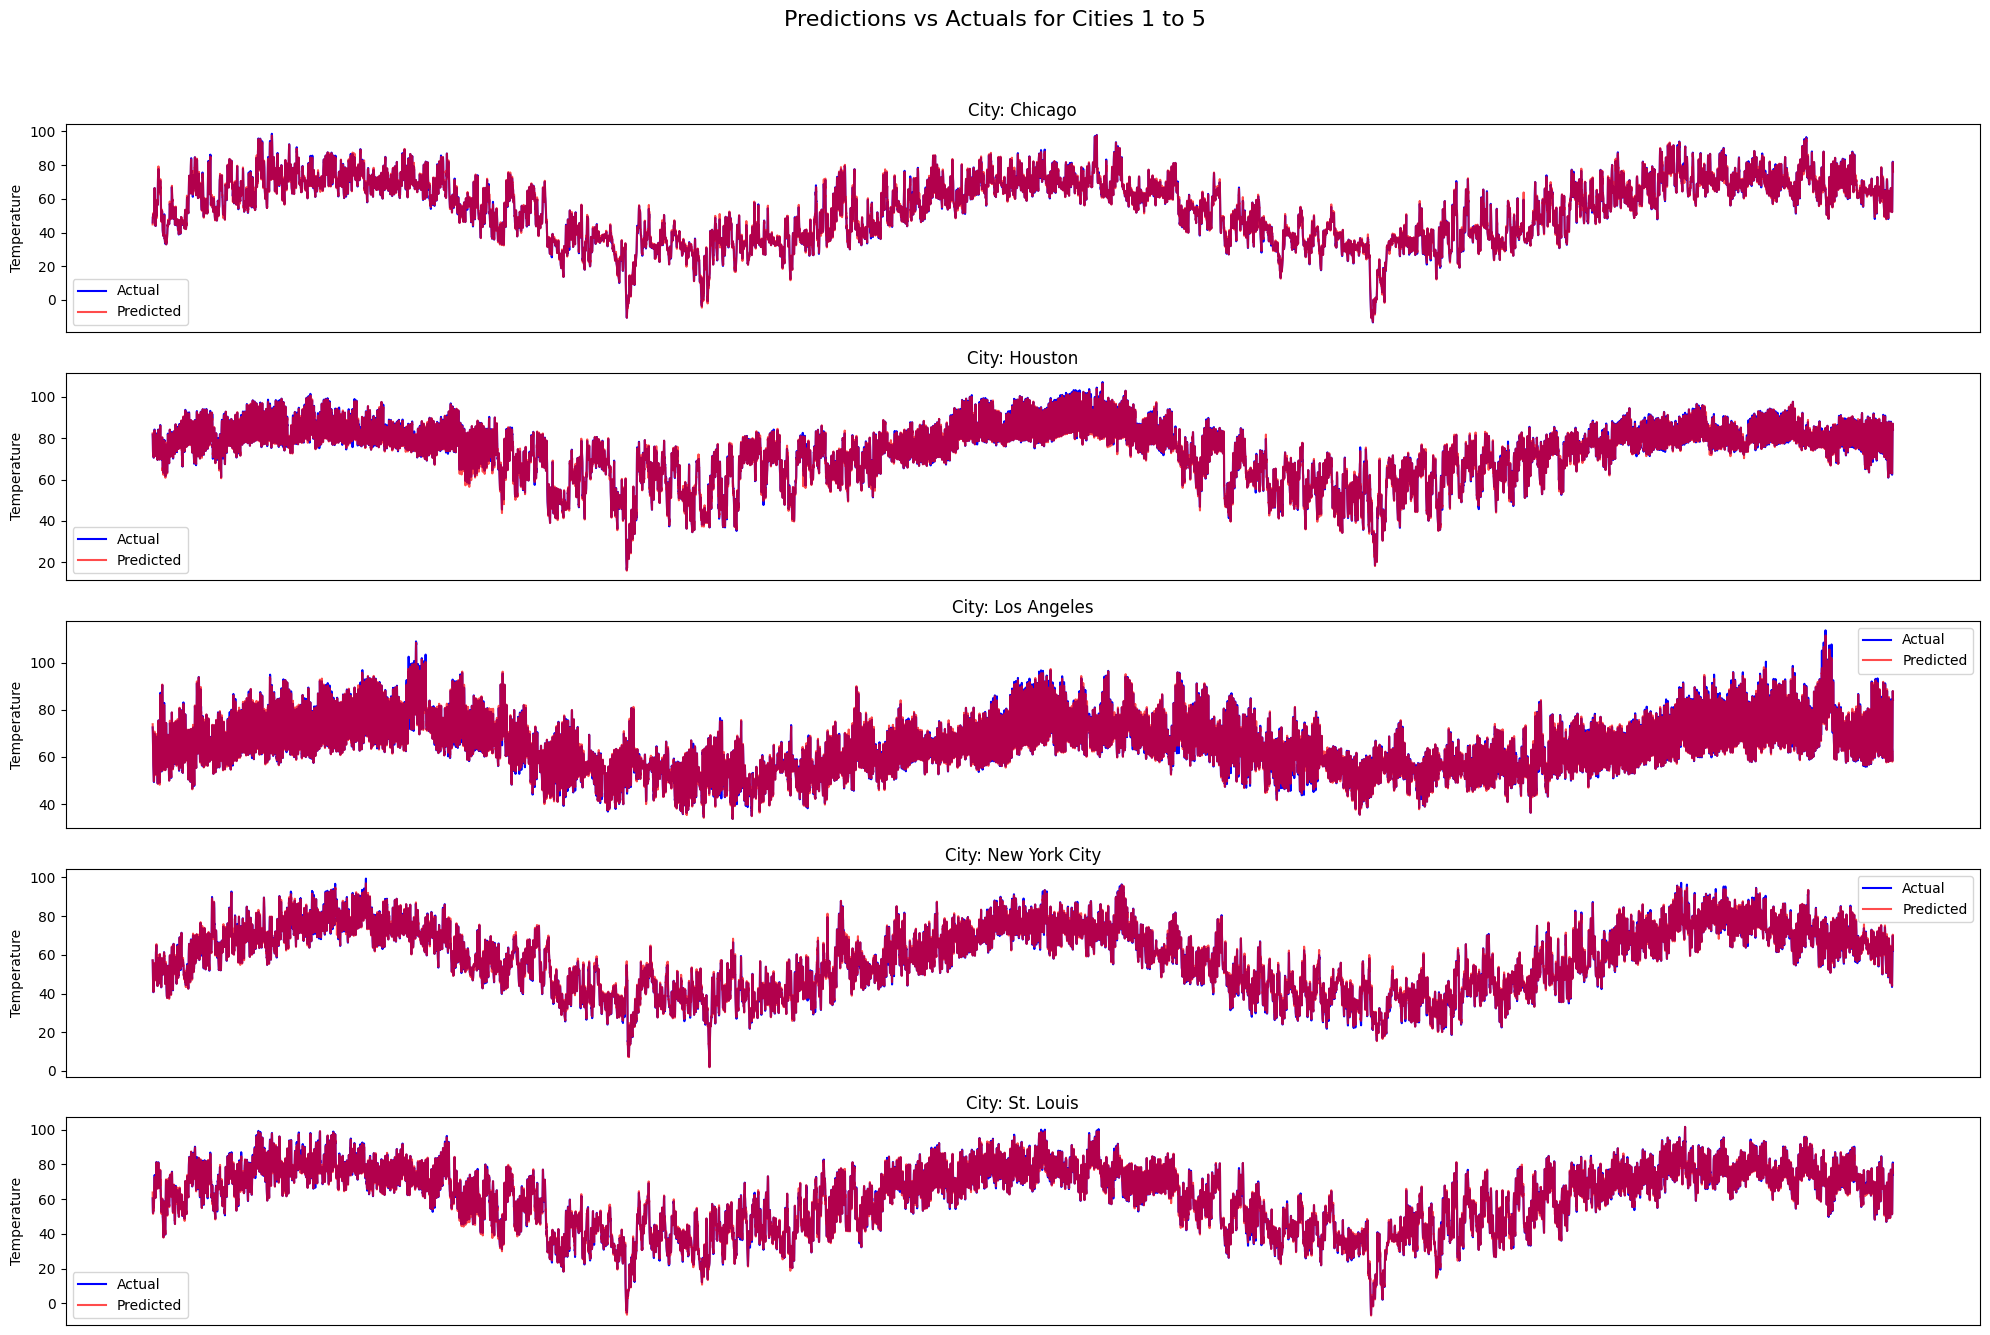

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Generate predictions on the test set, grouped by city
model.eval()
predictions = []
actuals = []
city_indices = []

with torch.no_grad():
    for X_batch, y_batch, city_batch in test_loader:
        output = model(X_batch, city_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())
        city_indices.extend(city_batch.cpu().numpy())

# Convert lists to NumPy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()
city_indices = np.array(city_indices)

# Get unique city indices for plotting city-wise
unique_cities = np.unique(city_indices)
num_cities = len(unique_cities)

# Plot predictions vs actual values for each city with subplots, 5 per figure
cities_per_fig = 5
num_figs = int(np.ceil(num_cities / cities_per_fig))

for fig_num in range(num_figs):
    start_idx = fig_num * cities_per_fig
    end_idx = min(start_idx + cities_per_fig, num_cities)
    cities_to_plot = unique_cities[start_idx:end_idx]
    
    fig, axes = plt.subplots(len(cities_to_plot), 1, figsize=(20, 14))
    fig.suptitle(f'Predictions vs Actuals for Cities {start_idx + 1} to {end_idx}', fontsize=16)
    
    if len(cities_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot

    for ax, city_id in zip(axes, cities_to_plot):
        city_mask = city_indices == city_id
        city_predictions = predictions[city_mask]
        city_actuals = actuals[city_mask]
        
        # Get city name from mapping
        city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
        
        ax.plot(city_actuals, label='Actual', color='blue')
        ax.plot(city_predictions, label='Predicted', color='red', alpha=0.7)
        ax.set_title(f'City: {city_name}')
        
        ax.set_ylabel('Temperature')
        # Remove x-axis values
        ax.set_xticks([])
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


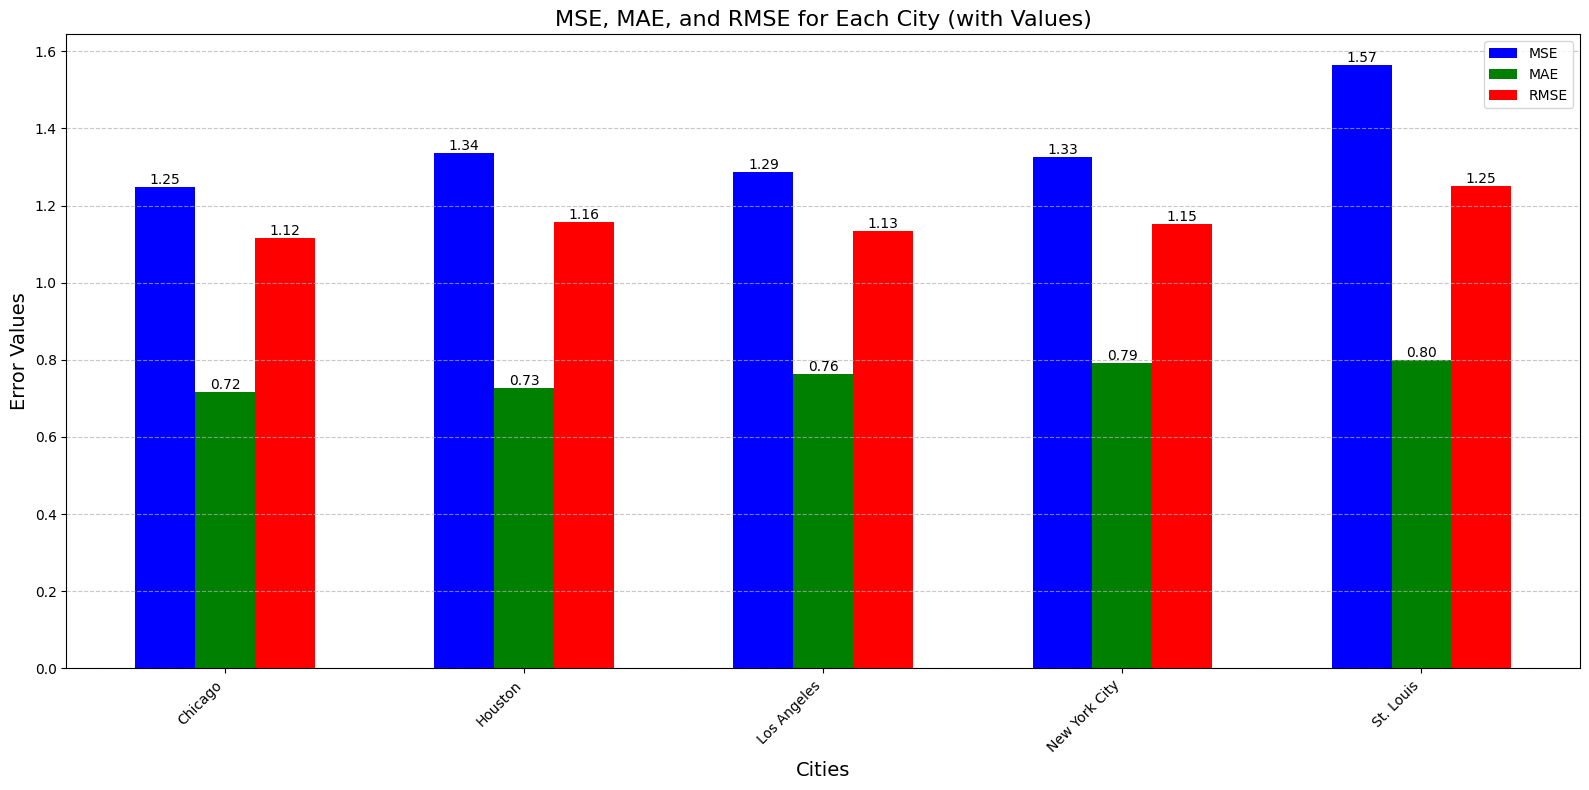

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Initialize a dictionary to store metrics for each city
city_metrics = {}

# Loop through each unique city index
for city_id in np.unique(city_indices):
    # Mask to filter data for the current city
    city_mask = city_indices == city_id
    city_predictions = predictions[city_mask]
    city_actuals = actuals[city_mask]
    
    # Calculate metrics
    mse = mean_squared_error(city_actuals, city_predictions)
    mae = mean_absolute_error(city_actuals, city_predictions)
    rmse = np.sqrt(mse)
    
    # Get the city name
    city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
    
    # Store metrics
    city_metrics[city_name] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Prepare data for plotting
cities = list(city_metrics.keys())
mse_values = [metrics["MSE"] for metrics in city_metrics.values()]
mae_values = [metrics["MAE"] for metrics in city_metrics.values()]
rmse_values = [metrics["RMSE"] for metrics in city_metrics.values()]

# Plot MSE, MAE, and RMSE as bar charts
x = np.arange(len(cities))  # City indices for the x-axis

plt.figure(figsize=(16, 8))

# Plot MSE
mse_bars = plt.bar(x - 0.2, mse_values, width=0.2, label='MSE', color='blue')

# Plot MAE
mae_bars = plt.bar(x, mae_values, width=0.2, label='MAE', color='green')

# Plot RMSE
rmse_bars = plt.bar(x + 0.2, rmse_values, width=0.2, label='RMSE', color='red')

# Add values on top of bars
for bars, values in zip([mse_bars, mae_bars, rmse_bars], [mse_values, mae_values, rmse_values]):
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            bar.get_height(),                  # Y position (top of the bar)
            f"{value:.2f}",                    # Value (rounded to 2 decimal places)
            ha='center', va='bottom', fontsize=10  # Alignment and font size
        )

# Add labels and title
plt.xticks(x, cities, rotation=45, ha='right')
plt.xlabel('Cities', fontsize=14)
plt.ylabel('Error Values', fontsize=14)
plt.title('MSE, MAE, and RMSE for Each City (with Values)', fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


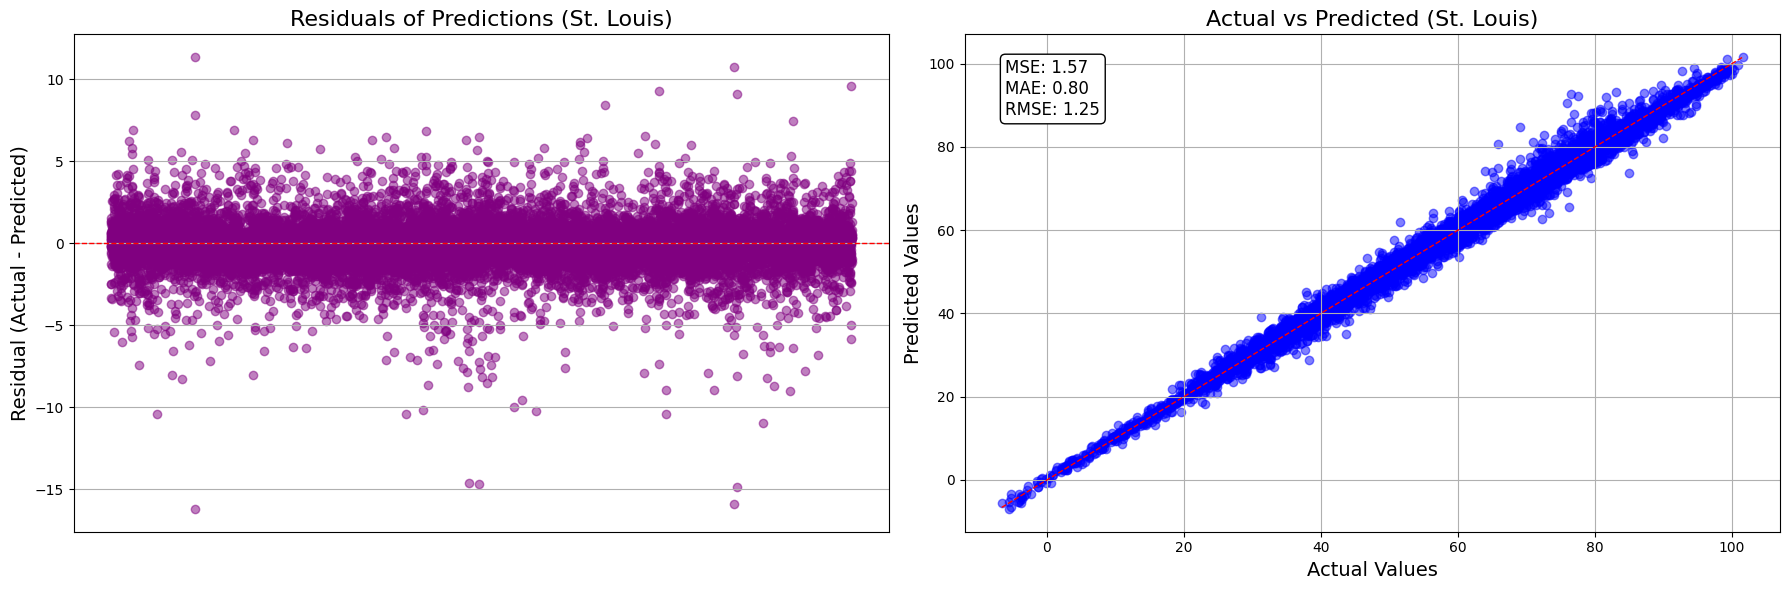

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Identify the city index for St. Louis
st_louis_idx = city_mapping[city_mapping['location_city'] == 'St. Louis']['city_idx'].values[0]

# Filter data for St. Louis
st_louis_mask = city_indices == st_louis_idx
st_louis_actuals = actuals[st_louis_mask]
st_louis_predictions = predictions[st_louis_mask]

# Calculate residuals for St. Louis
st_louis_residuals = st_louis_actuals - st_louis_predictions

# Calculate metrics for St. Louis
mse = mean_squared_error(st_louis_actuals, st_louis_predictions)
mae = mean_absolute_error(st_louis_actuals, st_louis_predictions)
rmse = np.sqrt(mse)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Residuals for St. Louis
axes[0].scatter(range(len(st_louis_residuals)), st_louis_residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals of Predictions (St. Louis)', fontsize=16)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=14)
axes[0].grid(True)
axes[0].set_xticks([])  # Remove x-axis values

# Subplot 2: Actual vs Predicted for St. Louis
axes[1].scatter(st_louis_actuals, st_louis_predictions, alpha=0.5, color='blue')
axes[1].plot([min(st_louis_actuals), max(st_louis_actuals)], 
             [min(st_louis_actuals), max(st_louis_actuals)], 
             color='red', linestyle='--', linewidth=1)  # Perfect prediction line
axes[1].set_title('Actual vs Predicted (St. Louis)', fontsize=16)
axes[1].set_xlabel('Actual Values', fontsize=14)
axes[1].set_ylabel('Predicted Values', fontsize=14)
axes[1].grid(True)

# Display error metrics on the second subplot
text_x = 0.05  # X-coordinate for text (relative to axis)
text_y = 0.95  # Y-coordinate for text (relative to axis)
axes[1].text(
    text_x, text_y, 
    f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Adjust layout
plt.tight_layout()
plt.show()
